# PCA Model Task

### 1) Data Preparation

Importing packages

In [230]:
import datetime
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import sys
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import fbeta_score

##### Reading the data, converting the time to timestamp and indexing the date to use it as a time series

In [231]:
#Data Paths
DATA_PATH = sys.path[0]+"\\data\\"
filename_train1="BATADAL_dataset03.csv"
filename_train2="BATADAL_dataset04.csv"
filename_test="BATADAL_test_dataset.csv"

#Reading the data
dftrain1  = pd.read_csv(DATA_PATH + filename_train1)
dftrain2  = pd.read_csv(DATA_PATH + filename_train2)
dftest  = pd.read_csv(DATA_PATH + filename_test)

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))

# Choosing 0 if not an anomaly and 1 if anomaly
dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

# Indexing
dftrain1=dftrain1.set_index('DATETIME')
dftrain2=dftrain2.set_index('DATETIME')
dftest=dftest.set_index('DATETIME')

#dftrain1.shift(1)

##### Dropping variables that are not meant to be used in for prediction (levers).

In [232]:
dftrain1=dftrain1.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'],axis=1)
dftrain2=dftrain2.drop([' S_PU1',' S_PU2',' S_PU3',' S_PU4',' S_PU5',' S_PU6',' S_PU7',' S_PU8', ' S_PU9',' S_PU10',' S_PU11',' S_V2'],axis=1)
dftest=dftest.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'],axis=1)

##### Labling the attacks on dftrain2 according to the information below

###### For L_T7
13/09/2016 23 - 16/09/2016 00 |
26/09/2016 11 - 27/09/2016 10
###### For F_PU10 and F_PU11
26/09/2016 11 - 27/09/2016 10
###### For L_T1
09/10/2016 9 - 11/10/2016 20 |
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For F_PU1 and F_PU2
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For L_T4
26/11/2016 17 - 29/11/2016 04

In [233]:
#L_T7
dftrain2_L_T7=dftrain2.loc[:,[' L_T7',' ATT_FLAG']]
dftrain2_L_T7.loc[:,' ATT_FLAG']=0
dftrain2_L_T7.loc['2016-09-13 23':'2016-09-16 00',' ATT_FLAG']=1
dftrain2_L_T7.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#F_PU10 and F_PU11
dftrain2_F_PU10=dftrain2.loc[:,[' F_PU10',' ATT_FLAG']]
dftrain2_F_PU10.loc[:,' ATT_FLAG']=0
dftrain2_F_PU10.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1

dftrain2_F_PU11=dftrain2.loc[:,[' F_PU11',' ATT_FLAG']]
dftrain2_F_PU11.loc[:,' ATT_FLAG']=0
dftrain2_F_PU11.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#L_T1
dftrain2_L_T1=dftrain2.loc[:,[' L_T1',' ATT_FLAG']]
dftrain2_L_T1.loc[:,' ATT_FLAG']=0
dftrain2_L_T1.loc['2016-10-09 09':'2016-10-11 20',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#F_PU1 and F_PU2
dftrain2_F_PU1=dftrain2.loc[:,[' F_PU1',' ATT_FLAG']]
dftrain2_F_PU1.loc[:,' ATT_FLAG']=0
dftrain2_F_PU1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1

dftrain2_F_PU2=dftrain2.loc[:,[' F_PU2',' ATT_FLAG']]
dftrain2_F_PU2.loc[:,' ATT_FLAG']=0
dftrain2_F_PU2.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU2.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#L_T4
dftrain2_L_T4=dftrain2.loc[:,[' L_T4',' ATT_FLAG']]
dftrain2_L_T4.loc[:,' ATT_FLAG']=0
dftrain2_L_T4.loc['2016-11-26 17':'2016-11-29 04',' ATT_FLAG']=1

#dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

#### Labling the attacks on dftest according to the batadal dataset

In [234]:
dftest[" ATT_FLAG"]=0
dftest.loc['2017-01-16 09':'2017-01-19 06',' ATT_FLAG']=1
dftest.loc['2017-01-30 08':'2017-02-02 00',' ATT_FLAG']=1
dftest.loc['2017-02-09 03':'2017-02-10 09',' ATT_FLAG']=1
dftest.loc['2017-02-12 01':'2017-02-13 07',' ATT_FLAG']=1
dftest.loc['2017-02-24 05':'2017-02-28 08',' ATT_FLAG']=1
dftest.loc['2017-03-10 14':'2017-03-13 21',' ATT_FLAG']=1
dftest.loc['2017-03-25 20':'2017-03-27 01',' ATT_FLAG']=1

#### Labling the type of anomalies according to the analysis done for the Discrete Model Task

In [275]:
dftest.loc['2017-01-30 08':'2017-02-02 00', 'anomalytype']="collective"
dftest.loc['2017-02-09 02':'2017-02-10 09', 'anomalytype']="collective"
dftest.loc['2017-02-12 00':'2017-02-13 07', 'anomalytype']="collective"
dftest.loc['2017-02-24 05':'2017-02-28 08', 'anomalytype']="collective"
dftest.loc['2017-03-10 14':'2017-03-13 21', 'anomalytype']="collective"
dftest.loc['2017-01-16 09':'2017-01-19 06', 'anomalytype']="contextual"
dftest.loc['2017-03-25 20':'2017-03-27 01', 'anomalytype']="collective"

##### Normalizing the data

All columns but the last column with the binary classification of anomaly.

In [235]:
#Obs: some values will be converted to float
dftrain1_normalized=dftrain1
dftrain2_normalized=dftrain2
dftest_normalized=dftest
#Dftrain1
dftrain1_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftrain1.iloc[:,range(0,31)])
#Dftrain2
dftrain2_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftrain2.iloc[:,range(0,31)])
#Dftest
dftest_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftest.iloc[:,range(0,31)])

C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


## 2) PCA Algorithm

_Observation: some of the code used here was derived from the website: This method was derived from: https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html that performed a similar analisis using PCA_

#### Running the PCA for the entire train dataset 1
Running the PCA, reversing the PCA to rebuild the dataset and storing it in a dataframe

In [236]:
#Creating the function
def pca_reverse_trasformation(n_components,random_state,df):
    #Creating PCA model
    pca = PCA(n_components=n_components, whiten=False, random_state=random_state)
    #Applyting PCA transformation to dataset
    df_PCA = pca.fit_transform(df)
    #Saving in a dataframe format
    df_PCA = pd.DataFrame(data=df_PCA, index=df.index)
    #Reversing the PCA
    df_PCA_inverse = pca.inverse_transform(df_PCA)
    #Saving in a dataframe format
    df_PCA_inverse = pd.DataFrame(data=df_PCA_inverse,index=df.index)
    return df_PCA_inverse

#Applying the function
n_components = 10
random_state = 27
df=dftrain1_normalized
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

#### Calculating the residuals


Function that calculate the residuals of a PCA prediction for a column in a dataframe

In [237]:
def residuals_pca(original_column,pca_column):
    #Creating DF with the selected column from the transformed dataset
    PCA_df=pd.DataFrame(data=pca_column,index=pca_column.index)
    PCA_df.columns = ['transformed']
    PCA_df["original"]=original_column
    #Calculating the residuals
    PCA_df["residuals"]=PCA_df["original"]-PCA_df['transformed']
    return  PCA_df

Testing for the column "L_T4"

Text(0, 0.5, 'Normalized Residuals')

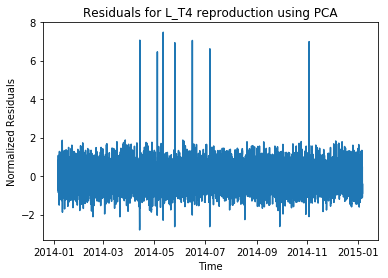

In [238]:
#Testing
original_column=dftrain1_normalized["L_T4"]
pca_column=dftrain1_PCA_inverse[dftrain1_normalized.columns.get_loc("L_T4")]
PCA_L_T4=residuals_pca(original_column,pca_column)
#Plot
plt.plot(PCA_L_T4["residuals"])
plt.title('Residuals for L_T4 reproduction using PCA')
plt.xlabel('Time')
plt.ylabel('Normalized Residuals')

#### Analizing why the residuals occured for L_T4


Here we will compare how the normalized values for all the dimensions of observations with low residuals differ from the observations with high residuals

Ploting the normalized values for which the residual was high for every column

Text(0, 0.5, 'Normalized values')

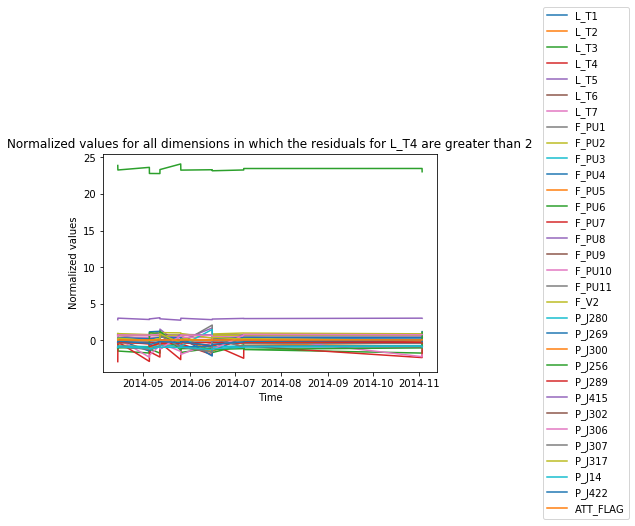

In [239]:
plt.plot(dftrain1_normalized[PCA_L_T4["residuals"]>2])
plt.legend(dftrain1_normalized.columns,loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.title('Normalized values for all dimensions in which the residuals for L_T4 are greater than 2')
plt.xlabel('Time')
plt.ylabel('Normalized values')

Ploting the normalized values for which the residual was normal/low for every column

Text(0, 0.5, 'Normalized values')

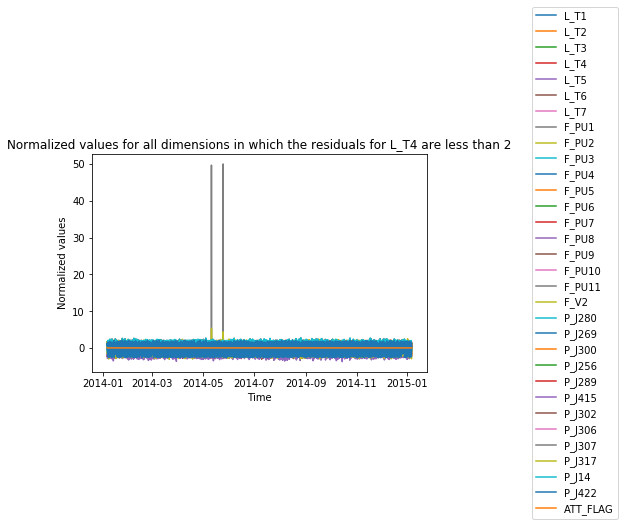

In [240]:
plt.plot(dftrain1_normalized[PCA_L_T4["residuals"]<2])
plt.legend(dftrain1_normalized.columns,loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.title('Normalized values for all dimensions in which the residuals for L_T4 are less than 2')
plt.xlabel('Time')
plt.ylabel('Normalized values')

Checking the mean value for F_PU6, which is the varaible with the greatest difference for the observations with high residuals in comparison to the observations with low residuals

In [241]:
#df.loc[:,"Score1"].mean()
print("F_PU6 Mean for low/normal residuals: "+ str(dftrain1_normalized.loc[PCA_L_T4["residuals"]<2]["F_PU6"].mean()))
print("F_PU6 Mean for high residuals: "+ str(dftrain1_normalized[PCA_L_T4["residuals"]>2]["F_PU6"].mean()))

F_PU6 Mean for low/normal residuals: -0.04276919693910875
F_PU6 Mean for high residuals: 23.376039202034715


Checking the mean value for P_J415, which is the varaible with the second greatest difference for the observations with high residuals in comparison to the observations with low residuals

In [242]:
#df.loc[:,"Score1"].mean()
print("P_J415 Mean for low/normal residuals: "+ str(dftrain1_normalized.loc[PCA_L_T4["residuals"]<2]["P_J415"].mean()))
print("P_J415 Mean for high residuals: "+ str(dftrain1_normalized[PCA_L_T4["residuals"]>2]["P_J415"].mean()))

P_J415 Mean for low/normal residuals: -0.0053904225342086476
P_J415 Mean for high residuals: 2.946202816353262


#### Dropping columns that produced outliers

In order to reduce the residuals in the dftrain1, we will drop the columns that produced such big residuals

In [243]:
dftrain1_normalized_nooutlier=dftrain1_normalized.drop(['F_PU6','P_J415'],axis=1)
dftrain2_normalized_nooutlier=dftrain2_normalized.drop([' F_PU6',' P_J415'],axis=1)
dftest_normalized_nooutlier=dftest_normalized.drop(['F_PU6','P_J415'],axis=1)

Testing if the big residuals are gone

Text(0, 0.5, 'Normalized Residuals')

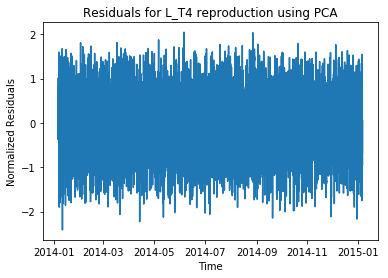

In [244]:
#Applying the PCA
n_components = 10
random_state = 27
df=dftrain1_normalized_nooutlier
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

original_column=dftrain1_normalized["L_T4"]
pca_column=dftrain1_PCA_inverse[dftrain1_normalized.columns.get_loc("L_T4")]
PCA_L_T4=residuals_pca(original_column,pca_column)
#Plot
plt.plot(PCA_L_T4["residuals"])
plt.title('Residuals for L_T4 reproduction using PCA')
plt.xlabel('Time')
plt.ylabel('Normalized Residuals')

# 3) Functions to aid Anomaly Prediction

In order to predict anomalies we need to have a "score" that is proportional to the probability of a given observation to be an anomaly. Thus, a threshold can be defined that consider an anomaly when this "score" is higher it.

### Reverse Anomaly Scores

The transactions that have the largest sum of squared differences will have an error close to zero, while those that have the smallest sum of squared differences will have an error close to one.

In [245]:
def AnomalyScore(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    #Scaling between 0 and 1
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

An anomaly value function will be created that will be used to select the threshold for the anomaly score. The idea is that for a dataset without anomalies the maximum anomaly value should be the threshold.

In [246]:
def AnomalyValue(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    return loss

### Predicting outliers and calculating performance indicators

The function below receive the dataset, the truelabels, the n_pca_components and the threshold and output performance indicators like a confusion matrix, the recall, precision, acuracy and the F-Score

In [247]:
def pca_predict(dataset,truelabels,n_pca_components,threshold,Anomaly="Scores"):
   
    #One random number was picked for the random state
    random_state=27
    ###Generating the model for the data set###
    dataset_PCA_inverse=pca_reverse_trasformation(n_pca_components,random_state,dataset)

    ###Anomaly scores
    if Anomaly=="Scores":
        #Using anomaly scores
        AnomalyScoresPCA=AnomalyScore(dataset, dataset_PCA_inverse)
        AnomalyScoresPCA=pd.Series.to_frame(AnomalyScoresPCA)
        AnomalyScoresPCA.columns=["AnomalyScore"]
    else:
        ###Using Anomaly values
        AnomalyScoresPCA=AnomalyScore(dataset, dataset_PCA_inverse)
        AnomalyScoresPCA=pd.Series.to_frame(AnomalyScoresPCA)
        AnomalyScoresPCA.columns=["AnomalyScore"]
    
    ###Predicting
    AnomalyScoresPCA['predictions']=AnomalyScoresPCA['AnomalyScore'].apply(lambda x: 1 if x>threshold else 0)
    
    ###Calculating the performance
    cm=confusion_matrix(list(truelabels), list(AnomalyScoresPCA['predictions']))
    if cm.shape==(3,3):
        cm=cm[(0,2),1:]
    #True positive, false positive, false negative and true positive
    tn, fp, fn, tp = cm.ravel()
    #Getting the ratios
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    #F-score
    F_score=fbeta_score(list(truelabels), list(AnomalyScoresPCA['predictions']), beta=0.5)
    #Probability vector
    performance={"recall":recall,"precision":precision,"Accuracy":accuracy,"F_score":F_score}
    
    return [cm,performance,AnomalyScoresPCA['predictions']]

The function below receives a confusion matrix and plot it in a better formated manner

In [248]:
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix - PCA'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])

# 4) Detecting anomalies in the training data set 2

### Detecting anomalies in dftrain2

We are going to train a model in dftrain1 just to select the best set of parameters (number of components for the PCA and threshold for anomaly scores) to use in the detection of dftrain2. 

#### Selecting the number of components for the PCA

First we are going the sum of the absolute value of the residuals per column in dftrain1 

([<matplotlib.axis.XTick at 0x231663a9a58>,
 <a list of 27 Text xticklabel objects>)

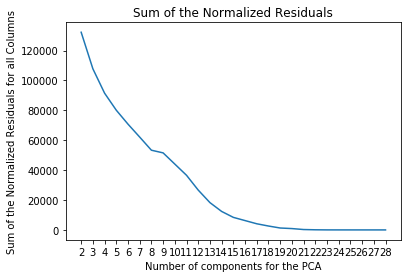

In [250]:
#Assigning random state
random_state = 27
#Creating dictinary to get all the sum of residuals for component
SumOfResiduals=dict()
#The dataframe that will be used for the model
df=dftrain1_normalized_nooutlier

#Looping through all the columns and getting the sum of residuals
for n_components in range(2,int(len(df.columns)-1)):
    dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)
    Sum_for_all_col=0
    for col in df.columns:
        Sum_for_all_col+=sum(residuals_pca(df[col],dftrain1_PCA_inverse[df.columns.get_loc(col)])['residuals'].apply(lambda x: abs(x)))
    SumOfResiduals[n_components]=Sum_for_all_col
    
#Ploting the sum of residuals
lists = sorted(SumOfResiduals.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Sum of the Normalized Residuals')
plt.xlabel('Number of components for the PCA')
plt.ylabel('Sum of the Normalized Residuals for all Columns')
plt.xticks(x)

After about __19__ it seems that there is no significant improvement in the performance of the algorithm so the number of components for the PCA will be 19

#### Selecting the threshold

Running the model for 19 components

In [251]:
n_components=19
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)
df=dftrain1_normalized_nooutlier

Checking the anomalis value and getting the 80% percentil as an anomaly (assuming that roughly a 80% of accuracy is good enough)

Text(0, 0.5, 'Anomaly Values')

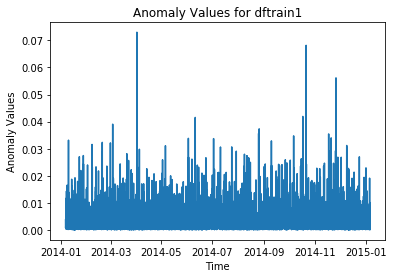

In [252]:
#Calculating anomaly values
anomaly_values=AnomalyValue(df, dftrain1_PCA_inverse)
# Getting the threshold
threshold_dftrain1=np.percentile(np.array(anomaly_values), 80, axis=0)
#Ploting the anomalous values
plt.plot(anomaly_values)
plt.title('Anomaly Values for dftrain1')
plt.xlabel('Time')
plt.ylabel('Anomaly Values')

#### Running the model

Predicting anomalies in dftrain2 using n_pca_components=19 and the 75% percentile of the anomaly values as a threshold

{'recall': 0.182648401826484, 'precision': 0.17699115044247787, 'Accuracy': 0.9126167105578166, 'F_score': 0.17809439002671415}


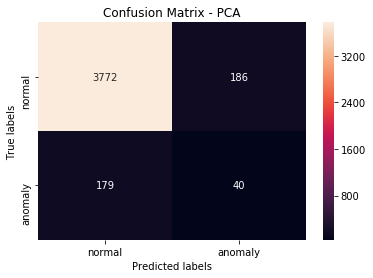

In [253]:
dataset=dftrain2_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftrain2_normalized_nooutlier[' ATT_FLAG']
n_pca_components=19
threshold=threshold_dftrain1
PCA_model_trainset2=pca_predict(dataset,truelabels,n_pca_components,threshold,Anomaly="values")
ploting_cm(PCA_model_trainset2[0])
print(PCA_model_trainset2[1])

# 5) Detecting anomalies in the test set

Looping through a parameter space to select the best set of parameters for the dftrain2 to be used in dftest (instead of selecting parameters by looking into the residuals). Thus, it is possible to use the anomaly_score instead of the anomaly_value as a threshold

In [254]:
#Creating a first model just to initialize the loop
dataset=dftrain2_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftrain2_normalized_nooutlier[' ATT_FLAG']
n_pca_components=19
threshold=0.05
parameters=[threshold,n_pca_components]
best_PCA_model=pca_predict(dataset,truelabels,n_pca_components,threshold)
#Looping
n_dimensions=len(dataset.columns)
for t in [0.0001,0.0005,0.001,0.005,0.01,0.04,0.045,0.05,0.055,0.06,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
    for p in range(2,n_dimensions-1):
        PCA_model=pca_predict(dataset,truelabels,p,t)
        if PCA_model[1]['F_score']>best_PCA_model[1]['F_score']:
            best_PCA_model=PCA_model
            parameters=[t,p]
#Checking the result
print(best_PCA_model[1])

{'recall': 0.2237442922374429, 'precision': 0.5268817204301075, 'Accuracy': 0.9487670576969116, 'F_score': 0.41455160744500846}
[0.045, 17]


Predicting anomalies in dftest using the parameters selected by the loop before

{'recall': 0.5036855036855037, 'precision': 0.7564575645756457, 'Accuracy': 0.8717089516515079, 'F_score': 0.6874580818242789}
Threshold for Outlier Score: 0.045
PCA Components: 17


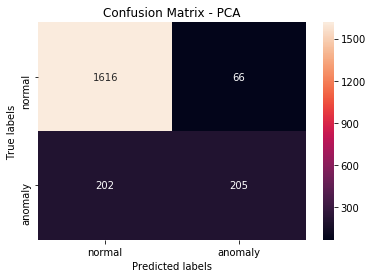

In [311]:
#Assigning the model parameters
dataset=dftest_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftest_normalized_nooutlier[' ATT_FLAG']
n_pca_components=parameters[1]
threshold=parameters[0]
PCA_model_testset=pca_predict(dataset,truelabels,n_pca_components,threshold)
ploting_cm(PCA_model_testset[0])
print(PCA_model_testset[1])
print("Threshold for Outlier Score: "+str(parameters[0]))
print("PCA Components: "+str(parameters[1]))   

### Checking the type of anomaly predicted

Getting the anomalies prediction

In [259]:
#Getting the predictions for anomalies
dftest_with_predictions=dftest
dftest_with_predictions["predictions"]=PCA_model_testset[2]
#Creating a column with them in the test set
#dftest[dftest["predictions"]==1].index

Calculating per each type of anomaly the recall rate

In [276]:
#Calculating number of anomalies per type
Total_Collective_Anomalies=len(dftest_with_predictions[dftest_with_predictions["anomalytype"]=="collective"])
Total_Contextual_Anomalies=len(dftest_with_predictions[dftest_with_predictions["anomalytype"]=="contextual"])

#Calculating number of anomalies predicted per type
Predicted_Collective_Anomalies=len(dftest_with_predictions[(dftest_with_predictions["anomalytype"]=="collective") & (dftest_with_predictions["predictions"]==1)])
Predicted_Contextual_Anomalies=len(dftest_with_predictions[(dftest_with_predictions["anomalytype"]=="contextual") & (dftest_with_predictions["predictions"]==1)])

#Ratio - percentage predicted
Percentage_Collective_Predicted=Predicted_Collective_Anomalies/Total_Collective_Anomalies
Percentage_Contextual_Predicted=Predicted_Contextual_Anomalies/Total_Contextual_Anomalies

print("Percentage of Collective Anomalies Predicted: "+str(Percentage_Collective_Predicted))
print("Percentage of Contextual Anomalies Predicted: "+str(Percentage_Contextual_Predicted))


Percentage of Collective Anomalies Predicted: 0.49557522123893805
Percentage of Contextual Anomalies Predicted: 0.5285714285714286


Ploting the predicted values vs the true values for the anomalies

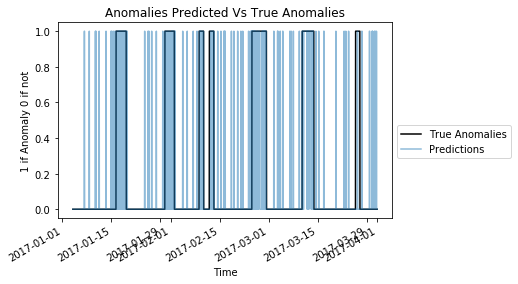

In [304]:
#Ploting the anomalous values
fig=plt.figure()
plt.plot(dftest_with_predictions[" ATT_FLAG"],label="True Anomalies",color="black")
plt.plot(dftest_with_predictions["predictions"],label="Predictions",alpha=0.5)
fig.autofmt_xdate()
plt.title('Anomalies Predicted Vs True Anomalies')
plt.xlabel('Time')
plt.ylabel('1 if Anomaly 0 if not')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))